In [1]:
#torch cuda
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#Importar torch 

import torch.nn as nn
from torch.utils.data import DataLoader

In [3]:
#Cargar data set

import os
import numpy as np
from PIL import Image

def load_dataset(folder_path,file_extension):

    # Obtener la lista de archivos en la carpeta
    file_list = os.listdir(folder_path)

    # Filtrar los archivos por extensión (por ejemplo, solo archivos JPG)
    jpg_files = [file_name for file_name in file_list if file_name.endswith("."+file_extension)]

    # Crear una lista vacía para almacenar las imágenes
    images = []

    # Recorrer la lista de archivos JPG
    for file_name in jpg_files:
        # Combinar la ruta de la carpeta con el nombre del archivo
        file_path = os.path.join(folder_path, file_name)

        # Abrir la imagen usando PIL
        image = Image.open(file_path)

        # Convertir la imagen a un arreglo numpy
        image_np = np.array(image)

        # Agregar la imagen al listado de imágenes
        images.append(image_np)

    # Convertir la lista de imágenes a un arreglo numpy
    dataset = np.array(images, dtype=object)

    return dataset

x_train_path = "/kaggle/input/crack50020220509t090436z001/CRACK500/traincrop/traincrop"
y_train_path = "/kaggle/input/crack50020220509t090436z001/CRACK500/traincrop/traincrop"

imagenes_grietas = load_dataset(x_train_path,"jpg")
localizcion_grietas = load_dataset(y_train_path,"png")
# Verificar la forma del arreglo x_train
print(imagenes_grietas.shape)
print(localizcion_grietas.shape)


(1896,)
(1896,)


In [4]:
#Convertir la imagen png en blanco y negro y no en un true/false

def boolean_to_grayscale(img):
    return np.where(img, 255, 0).astype('uint8')

localizcion_grietas = [boolean_to_grayscale(img) for img in localizcion_grietas]



In [6]:
# Reescalar las imagenes

import cv2
import numpy as np

# Especifica el tamaño deseado para las imágenes
target_size = (64, 64)

def img_resize(target_size, dataset):
    # Crea una lista para almacenar las imágenes redimensionadas
    resized_images = []

    # Itera sobre las imágenes en x_train y redimensiona cada una
    for img in dataset:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)

    # Convierte la lista de imágenes redimensionadas en un arreglo numpy
    dataset_resized = np.array(resized_images)
    
    return dataset_resized

imagenes_grietas_resized = img_resize(target_size, imagenes_grietas)
localizcion_grietas_resized = img_resize(target_size,localizcion_grietas)

#Invertimos la imagen
#y_train_resized = 255-y_train_resized


print(imagenes_grietas_resized.shape)
print(localizcion_grietas_resized.shape)


(1896, 64, 64, 3)
(1896, 64, 64)


In [7]:
#Convertir las imagenes de las grietas de blanco y negro a dos colores rojo y azul

import numpy as np

def convert_image(img):
    # Crear una imagen vacía con 3 canales para representar el BGR
    color_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    # Asignar el color rojo a los píxeles negros y el color azul a los píxeles blancos
    color_img[img == 0, 2] = 255  # canal rojo
    color_img[img == 255, 0] = 255  # canal azul

    return color_img

def convert_images(imgs):
    # Aplicar la conversión a cada imagen
    converted_imgs = np.array([convert_image(img) for img in imgs])
    return converted_imgs

# Para usar la función con un conjunto de imágenes:
# suponiendo que 'bw_images' es tu conjunto de imágenes en escala de grises
# color_images = convert_images(bw_images)


localizcion_grietas_resized = convert_images(localizcion_grietas_resized)
print(localizcion_grietas_resized.shape)

(1896, 64, 64, 3)


In [9]:
#Ahora empezamos a girar las imagenes en 90,180,270

import numpy as np
from scipy.ndimage import rotate

def rotate_images(images, angles=[90, 180, 270]):
    # Crear una lista vacía para almacenar las imágenes rotadas
    rotated_images = []
    
    # Iterar sobre todas las imágenes y ángulos de rotación
    for image in images:
        for angle in angles:
            rotated_image = rotate(image, angle, reshape=False)
            rotated_images.append(rotated_image)
    
    # Convertir la lista de imágenes rotadas en un array numpy
    rotated_images = np.array(rotated_images)
    
    return rotated_images

imagenes_grietas_resized=rotate_images(imagenes_grietas_resized)
localizcion_grietas_resized=rotate_images(localizcion_grietas_resized)

In [10]:
#Vale necesito pasar las imagenes a un tensor y normalizarlas
imagenes_grietas_tensor = torch.from_numpy(imagenes_grietas_resized).float()
imagenes_grietas_tensor = imagenes_grietas_tensor / 255  # Esto lo normalizará al rango de 0 a 1
#Vale necesito pasar las imagenes a un tensor  y normalizarlas
localizcion_grietas_tensor = torch.from_numpy(localizcion_grietas_resized).float()
localizcion_grietas_tensor = localizcion_grietas_tensor / 255  # Esto lo normalizará al rango de 0 a 1


In [11]:
# Arquitectura de la red
# Doble convolucion
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Generador
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.middle = DoubleConv(64, 128)
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            DoubleConv(128, 64),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        enc1 = self.encoder(x)
        enc2 = self.middle(enc1)
        dec = self.decoder(enc2)
        return dec

In [12]:
#Discriminador
class PatchGAN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.down1 = self.conv_and_norm(in_channels, 64, kernel_size=4, stride=2, padding=1, batch_norm=False)
        self.down2 = self.conv_and_norm(64, 128, kernel_size=4, stride=2, padding=1)
        self.down3 = self.conv_and_norm(128, 256, kernel_size=4, stride=2, padding=1)

        self.pad = nn.ZeroPad2d(1)
        self.conv = self.conv_and_norm(256, 512, kernel_size=4)
        
        self.pad2 = nn.ZeroPad2d(1)
        self.last = nn.Conv2d(512, 1, kernel_size=4)

    def forward(self, input, target):
        x = torch.cat([input, target], dim=1) 
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)

        x = self.pad(x)
        x = self.conv(x)
        
        x = nn.LeakyReLU(0.2)(x)
        
        x = self.pad2(x)
        x = self.last(x)
        return x

    def conv_and_norm(self, in_channels, out_channels, kernel_size, stride=1, padding=0, batch_norm=True):
        layers = []
        conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False) 
        layers.append(conv_layer)

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)


In [19]:
# Crea instancias de los modelos
generator = UNet(in_channels=3, out_channels=3).to(device)
discriminator = PatchGAN(in_channels=6).to(device)

#Hiperparametros
l1_lambda=10
batch_size=32
num_epochs = 500
lr=0.0002

# Definir la función de pérdida y los optimizadores
criterion = nn.BCEWithLogitsLoss()
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [23]:
#Data loader

from torch.utils.data import DataLoader, TensorDataset

# Asegúrate de que tus datos están en el dispositivo correcto
x_train_t = localizcion_grietas_tensor.to(device) #lo que va ser traducido 
y_train_t = imagenes_grietas_tensor.to(device)    #la traduccion

# Convertir los datos en tensores y crear el conjunto de datos
dataset = TensorDataset(x_train_t, y_train_t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [24]:
# Función para mostrar las imágenes generadas

import matplotlib.pyplot as plt

def show_generated_images(images):
    num_images = images.size(0)
    fig, axs = plt.subplots(1, num_images, figsize=(10, 10))

    for i in range(num_images):
        image = images[i].permute(1, 2, 0).cpu().detach().numpy()
        axs[i].imshow(image)
        axs[i].axis('off')

    plt.show()

Epoch 1/100:   2%|▏         | 4/178 [00:00<00:16, 10.83it/s]

Epoch [1/100], Step [1/178], Discriminator Loss: 7.1063, Generator Loss: 7.1349


Epoch 1/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.91it/s]

Epoch [1/100], Step [101/178], Discriminator Loss: 1.3143, Generator Loss: 2.0791


Epoch 1/100: 100%|██████████| 178/178 [00:24<00:00,  7.26it/s]


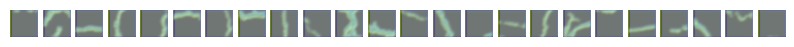

Epoch 2/100:   2%|▏         | 4/178 [00:00<00:13, 12.97it/s]

Epoch [2/100], Step [1/178], Discriminator Loss: 1.0152, Generator Loss: 2.4085


Epoch 2/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.83it/s]

Epoch [2/100], Step [101/178], Discriminator Loss: 1.3583, Generator Loss: 1.9304


Epoch 2/100: 100%|██████████| 178/178 [00:24<00:00,  7.20it/s]


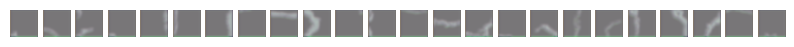

Epoch 3/100:   2%|▏         | 4/178 [00:00<00:13, 13.11it/s]

Epoch [3/100], Step [1/178], Discriminator Loss: 0.9822, Generator Loss: 2.3858


Epoch 3/100:  58%|█████▊    | 104/178 [00:14<00:09,  8.00it/s]

Epoch [3/100], Step [101/178], Discriminator Loss: 1.6454, Generator Loss: 2.1246


Epoch 3/100: 100%|██████████| 178/178 [00:24<00:00,  7.33it/s]


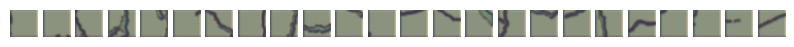

Epoch 4/100:   2%|▏         | 4/178 [00:00<00:13, 13.21it/s]

Epoch [4/100], Step [1/178], Discriminator Loss: 1.0856, Generator Loss: 2.8823


Epoch 4/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.98it/s]

Epoch [4/100], Step [101/178], Discriminator Loss: 0.4851, Generator Loss: 3.6026


Epoch 4/100: 100%|██████████| 178/178 [00:24<00:00,  7.31it/s]


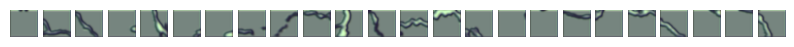

Epoch 5/100:   2%|▏         | 4/178 [00:00<00:13, 13.18it/s]

Epoch [5/100], Step [1/178], Discriminator Loss: 0.6481, Generator Loss: 3.1769


Epoch 5/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.89it/s]

Epoch [5/100], Step [101/178], Discriminator Loss: 0.6196, Generator Loss: 4.2165


Epoch 5/100: 100%|██████████| 178/178 [00:24<00:00,  7.24it/s]


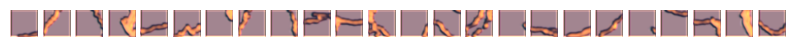

Epoch 6/100:   2%|▏         | 4/178 [00:00<00:13, 13.00it/s]

Epoch [6/100], Step [1/178], Discriminator Loss: 0.1574, Generator Loss: 5.4937


Epoch 6/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.90it/s]

Epoch [6/100], Step [101/178], Discriminator Loss: 0.1304, Generator Loss: 8.3570


Epoch 6/100: 100%|██████████| 178/178 [00:24<00:00,  7.27it/s]


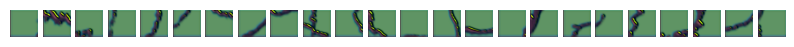

Epoch 7/100:   2%|▏         | 4/178 [00:00<00:13, 13.07it/s]

Epoch [7/100], Step [1/178], Discriminator Loss: 0.3402, Generator Loss: 5.4599


Epoch 7/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.97it/s]

Epoch [7/100], Step [101/178], Discriminator Loss: 0.2467, Generator Loss: 5.0063


Epoch 7/100: 100%|██████████| 178/178 [00:24<00:00,  7.29it/s]


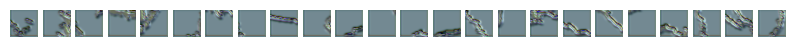

Epoch 8/100:   2%|▏         | 4/178 [00:00<00:13, 13.12it/s]

Epoch [8/100], Step [1/178], Discriminator Loss: 0.1736, Generator Loss: 5.5836


Epoch 8/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.89it/s]

Epoch [8/100], Step [101/178], Discriminator Loss: 0.5548, Generator Loss: 4.1911


Epoch 8/100: 100%|██████████| 178/178 [00:24<00:00,  7.26it/s]


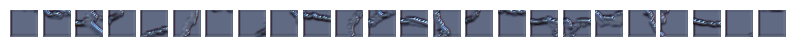

Epoch 9/100:   2%|▏         | 4/178 [00:00<00:13, 13.07it/s]

Epoch [9/100], Step [1/178], Discriminator Loss: 0.3116, Generator Loss: 4.0602


Epoch 9/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.92it/s]

Epoch [9/100], Step [101/178], Discriminator Loss: 0.3068, Generator Loss: 3.6389


Epoch 9/100: 100%|██████████| 178/178 [00:24<00:00,  7.26it/s]


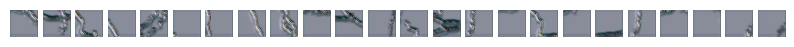

Epoch 10/100:   2%|▏         | 4/178 [00:00<00:13, 13.16it/s]

Epoch [10/100], Step [1/178], Discriminator Loss: 0.2876, Generator Loss: 4.5549


Epoch 10/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.94it/s]

Epoch [10/100], Step [101/178], Discriminator Loss: 0.1156, Generator Loss: 5.0664


Epoch 10/100: 100%|██████████| 178/178 [00:24<00:00,  7.27it/s]


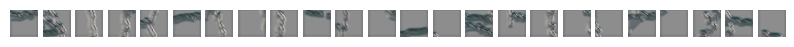

Epoch 11/100:   2%|▏         | 4/178 [00:00<00:13, 13.05it/s]

Epoch [11/100], Step [1/178], Discriminator Loss: 0.1380, Generator Loss: 5.6098


Epoch 11/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.94it/s]

Epoch [11/100], Step [101/178], Discriminator Loss: 0.1072, Generator Loss: 4.6241


Epoch 11/100: 100%|██████████| 178/178 [00:24<00:00,  7.28it/s]


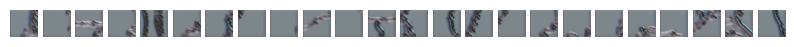

Epoch 12/100:   2%|▏         | 4/178 [00:00<00:13, 13.13it/s]

Epoch [12/100], Step [1/178], Discriminator Loss: 0.0741, Generator Loss: 5.4115


Epoch 12/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.90it/s]

Epoch [12/100], Step [101/178], Discriminator Loss: 0.0769, Generator Loss: 4.8253


Epoch 12/100: 100%|██████████| 178/178 [00:24<00:00,  7.29it/s]


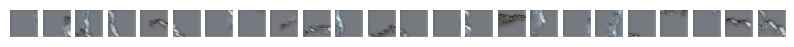

Epoch 13/100:   2%|▏         | 4/178 [00:00<00:13, 13.16it/s]

Epoch [13/100], Step [1/178], Discriminator Loss: 0.3097, Generator Loss: 4.8137


Epoch 13/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.91it/s]

Epoch [13/100], Step [101/178], Discriminator Loss: 0.1234, Generator Loss: 4.4327


Epoch 13/100: 100%|██████████| 178/178 [00:24<00:00,  7.27it/s]


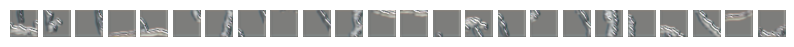

Epoch 14/100:   2%|▏         | 4/178 [00:00<00:13, 13.20it/s]

Epoch [14/100], Step [1/178], Discriminator Loss: 0.2860, Generator Loss: 6.3524


Epoch 14/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.93it/s]

Epoch [14/100], Step [101/178], Discriminator Loss: 0.0988, Generator Loss: 5.3030


Epoch 14/100: 100%|██████████| 178/178 [00:24<00:00,  7.26it/s]


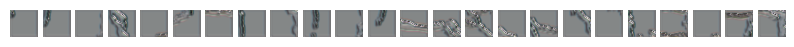

Epoch 15/100:   2%|▏         | 4/178 [00:00<00:13, 13.13it/s]

Epoch [15/100], Step [1/178], Discriminator Loss: 0.1058, Generator Loss: 4.3418


Epoch 15/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.89it/s]

Epoch [15/100], Step [101/178], Discriminator Loss: 0.0181, Generator Loss: 7.2399


Epoch 15/100: 100%|██████████| 178/178 [00:24<00:00,  7.26it/s]


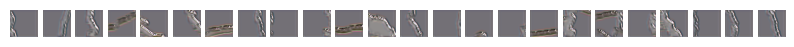

Epoch 16/100:   2%|▏         | 4/178 [00:00<00:13, 13.15it/s]

Epoch [16/100], Step [1/178], Discriminator Loss: 0.0467, Generator Loss: 5.9865


Epoch 16/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.95it/s]

Epoch [16/100], Step [101/178], Discriminator Loss: 3.1720, Generator Loss: 6.7304


Epoch 16/100: 100%|██████████| 178/178 [00:24<00:00,  7.27it/s]


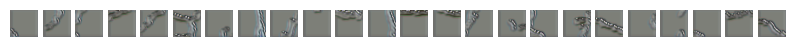

Epoch 17/100:   2%|▏         | 4/178 [00:00<00:13, 13.17it/s]

Epoch [17/100], Step [1/178], Discriminator Loss: 0.2162, Generator Loss: 4.3707


Epoch 17/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.91it/s]

Epoch [17/100], Step [101/178], Discriminator Loss: 0.0627, Generator Loss: 5.8091


Epoch 17/100: 100%|██████████| 178/178 [00:24<00:00,  7.26it/s]


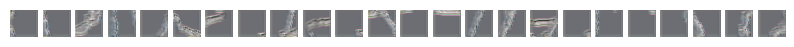

Epoch 18/100:   2%|▏         | 4/178 [00:00<00:13, 13.06it/s]

Epoch [18/100], Step [1/178], Discriminator Loss: 0.0536, Generator Loss: 5.5275


Epoch 18/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.85it/s]

Epoch [18/100], Step [101/178], Discriminator Loss: 0.0643, Generator Loss: 7.9878


Epoch 18/100: 100%|██████████| 178/178 [00:24<00:00,  7.25it/s]


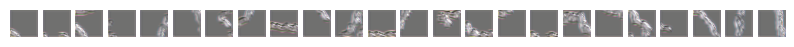

Epoch 19/100:   2%|▏         | 4/178 [00:00<00:13, 13.10it/s]

Epoch [19/100], Step [1/178], Discriminator Loss: 0.0620, Generator Loss: 7.7798


Epoch 19/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.89it/s]

Epoch [19/100], Step [101/178], Discriminator Loss: 0.0620, Generator Loss: 5.3052


Epoch 19/100: 100%|██████████| 178/178 [00:24<00:00,  7.25it/s]


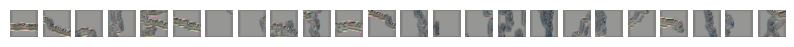

Epoch 20/100:   2%|▏         | 4/178 [00:00<00:13, 12.97it/s]

Epoch [20/100], Step [1/178], Discriminator Loss: 0.0707, Generator Loss: 5.6299


Epoch 20/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.93it/s]

Epoch [20/100], Step [101/178], Discriminator Loss: 0.0387, Generator Loss: 5.8893


Epoch 20/100: 100%|██████████| 178/178 [00:24<00:00,  7.25it/s]


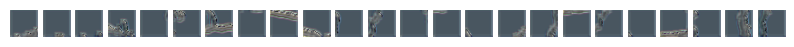

Epoch 21/100:   2%|▏         | 4/178 [00:00<00:13, 13.11it/s]

Epoch [21/100], Step [1/178], Discriminator Loss: 0.1996, Generator Loss: 4.2395


Epoch 21/100:  58%|█████▊    | 104/178 [00:14<00:09,  7.91it/s]

Epoch [21/100], Step [101/178], Discriminator Loss: 0.0644, Generator Loss: 5.2693


Epoch 21/100: 100%|██████████| 178/178 [00:24<00:00,  7.26it/s]


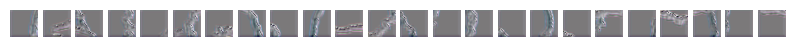

Epoch 22/100:   2%|▏         | 4/178 [00:00<00:13, 13.06it/s]

Epoch [22/100], Step [1/178], Discriminator Loss: 0.0119, Generator Loss: 6.7102


Epoch 22/100:  12%|█▏        | 21/178 [00:02<00:21,  7.22it/s]

In [ ]:
# Función de entrenamiento

import torch.nn.functional as F
from tqdm import tqdm

def train():
    for epoch in range(num_epochs):
        for i, (input_images, target_images) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            input_images = input_images.to(device)
            target_images = target_images.to(device)
            #input_images = input_images.unsqueeze(0)
            input_images = input_images.permute(0,3,1,2)
            target_images = target_images.permute(0,3,1,2)
             # Entrenar el discriminador
            discriminator_optimizer.zero_grad()

            fake_images = generator(input_images)
            real_outputs = discriminator(input_images, target_images)
            fake_outputs = discriminator(input_images, fake_images)

            discriminator_loss = criterion(real_outputs, torch.ones_like(real_outputs)) + \
                                 criterion(fake_outputs, torch.zeros_like(fake_outputs))
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # Entrenar el generador
            generator_optimizer.zero_grad()
            # Generar un nuevo conjunto de imágenes falsas
            fake_images = generator(input_images)

            fake_outputs = discriminator(input_images, fake_images)
            l1_loss = F.l1_loss(fake_images, target_images)
            generator_loss = criterion(fake_outputs, torch.ones_like(fake_outputs)) + l1_lambda * l1_loss
            generator_loss.backward()
            generator_optimizer.step()

            # Imprimir métricas de entrenamiento
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                      f"Discriminator Loss: {discriminator_loss.item():.4f}, "
                      f"Generator Loss: {generator_loss.item():.4f}")

        # Guardar imágenes generadas durante el entrenamiento
        with torch.no_grad():
            fake_samples = generator(input_images)
            show_generated_images(fake_samples)

# Entrenar el modelo
train()


In [ ]:
y_train_path = "/kaggle/input/crack50020220509t090436z001/CRACK500/testcrop/testcrop"
y_test= load_dataset(y_train_path,"png")

In [ ]:
y_test = [boolean_to_grayscale(img) for img in y_test][:10]
y_test = convert_images(y_test)

In [19]:
import numpy as np

# Asegúrate de que la imagen esté en el dispositivo correcto

input_image = torch.from_numpy(img_resize(target_size, y_test)).to(device)
input_image = input_image/255
#input_image = input_image.permute(1,2,3,0)
print(input_image.shape)

# Asegúrate de que la imagen tenga las dimensiones correctas
# Si la imagen es una imagen individual, es posible que necesites agregar una dimensión extra para el batch_size
if len(input_image.shape) == 3:
    input_image = input_image.unsqueeze(0) 
    
print(input_image.shape)    
input_image = input_image.permute(0,3,1,2)
print(input_image.shape)

# Generar la imagen de salida
with torch.no_grad():
    output_image = generator(input_image)

# La imagen generada puede estar en el rango [-1, 1] dependiendo de tu normalización,
# por lo que es posible que desees reescalarla al rango [0, 1] para visualización
output_images = output_image 

min_value = torch.min(output_images)
max_value = torch.max(output_images)
print(max_value)

torch.Size([10, 64, 64, 3])
torch.Size([10, 64, 64, 3])
torch.Size([10, 3, 64, 64])
tensor(0.9370, device='cuda:0')


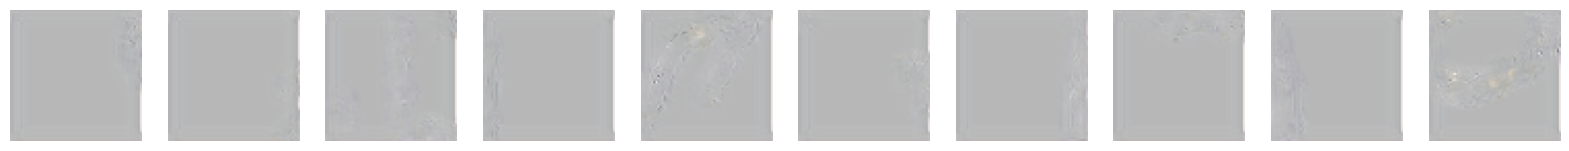

In [20]:
import matplotlib.pyplot as plt

# Asumiendo que `images` es tu tensor de imágenes
images = output_images

# Elige el número de imágenes a visualizar
num_images_to_show = 10

# Crea una figura para mostrar las imágenes
fig, axs = plt.subplots(1, num_images_to_show, figsize=(20, 20))

for i in range(num_images_to_show):
    # Toma la i-ésima imagen del tensor, la mueve al CPU, 
    # la convierte a un numpy array y la reorganiza a (height, width, channels)
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    
    # Si tus imágenes están en el rango [-1, 1] necesitas reescalarlas al rango [0, 1]
    img = (img + 1) / 2.0

    # Muestra la imagen
    axs[i].imshow(img)
    axs[i].axis('off')  # Oculta los ejes

plt.show()   
